In [ ]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Comparison with EventDisplay

**Purpose of this notebook:**

- Read DL2 files from _EventDisplay_ in FITS format

- Read _pyirf_ output

- Compare the outputs

**Notes:**

The following results correspond to:

- Paranal site
- Zd 20 deg, Az 180 deg
- 50 h observation time

**Resources:**

_EventDisplay_ DL2 data, https://forge.in2p3.fr/projects/cta_analysis-and-simulations/wiki/Eventdisplay_Prod3b_DL2_Lists

**TO-DOs:**

- ...

## Table of contents

* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Angular resolution](#Angular-resolution)
    - [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)
* [Differential sensitivity](#Differential-sensitivity)

## Imports

In [1]:
import numpy as np
import uproot
from astropy.io import fits
import matplotlib.pyplot as plt
import os

In [2]:
import astropy.units as u

## Definitions of classes and functions

If judged useful, these should be moved to pyirf!

## Input data

### _EventDisplay_

The input data provided by _EventDisplay_ is stored in _ROOT_ format, so _uproot_ is used to transform it into _numpy_ objects. 

In [3]:
# Path of EventDisplay IRF data in the user's local setup
# Please, empty the indir_EventDisplay variable before pushing to the repo
indir_EventDisplay = "../../data/event_display_irfs/data/WPPhys201890925LongObs/"
infile_EventDisplay = "DESY.d20180113.V3.ID0_180degNIM2LST4MST4SST4SCMST4.prod3b-paranal20degs05b-NN.S.3HB9-FD.180000s.root"

irf_eventdisplay = uproot.open(os.path.join(indir_EventDisplay, infile_EventDisplay))

In [4]:
# Contents of the ROOT file
# input_EventDisplay.keys()

### Setup of output data

## _pyirf_

The following is the current IRF + sensititivy output FITS format provided by this software.

### Differential sensitivity
[back to top](#Table-of-contents)

In [5]:
from astropy.table import QTable

In [33]:
# remove under/overflow bin
sensitivity = QTable.read('../sensitivity.fits.gz', hdu='SENSITIVITY')[1:-1]
sensitivity_step_2 = QTable.read('../sensitivity.fits.gz', hdu='SENSITIVITY_STEP_2')[1:-1]

In [34]:
sensitivity

reco_energy_low,reco_energy_center,reco_energy_high,n_signal,n_signal_weighted,n_background,n_background_weighted,relative_sensitivity,flux_sensitivity
TeV,TeV,TeV,,,,,,1 / (cm2 s TeV)
float64,float64,float64,int64,float64,int64,float64,float64,float64
0.012589254117941675,0.016270938633815235,0.0199526231496888,1129,4052.0534638085055,4,2992.527048409006,0.24087772804480675,3.308887876558572e-07
0.0199526231496888,0.025787699875686295,0.03162277660168379,30039,91562.76948280289,128,70110.96129089783,0.053132569583533434,2.1839677676726172e-08
0.03162277660168379,0.04087074998220551,0.05011872336272722,81059,199760.34109939943,199,88491.91010913285,0.01640720260062426,2.0179943490542266e-09
0.05011872336272722,0.06477577341757768,0.07943282347242814,87327,162217.5674365941,87,21069.0332801514,0.007146990744719955,2.6303202261989764e-10
0.07943282347242814,0.1026626823259224,0.12589254117941667,148820,206544.82726980548,73,14021.253022091143,0.004350767433290827,4.7912769368599987e-11
0.12589254117941667,0.1627093863381523,0.1995262314968879,159947,165880.4769129249,55,6700.891187969217,0.0036841277385645777,1.2140039080035877e-11
0.1995262314968879,0.2578769987568628,0.3162277660168378,63571,49130.40593400132,5,227.09398949419847,0.0024372665737508225,2.4031918205848773e-12
0.3162277660168378,0.4087074998220549,0.501187233627272,91317,53854.346008459455,14,397.0560834045755,0.0028687615107831827,8.464081769258541e-13


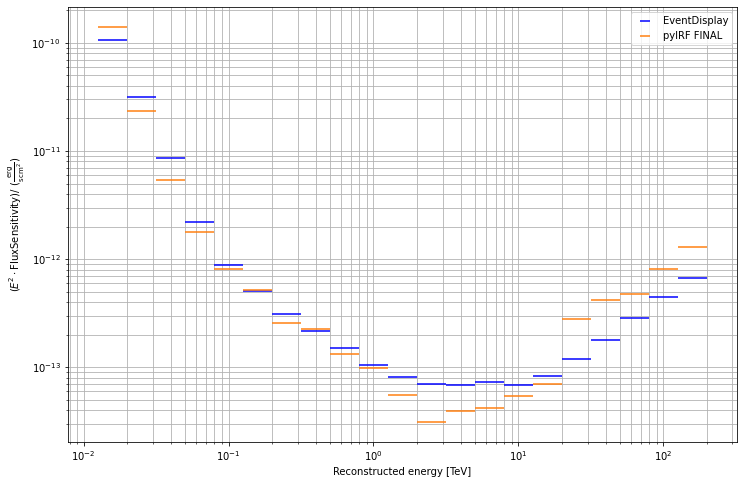

In [35]:
plt.figure(figsize=(12,8))

# Data
h = irf_eventdisplay["DiffSens"]

#x = np.asarray([(x_bin[1]+x_bin[0])/2. for x_bin in h.allbins[2:-1]])
bins = 10**h.edges
x = 0.5 * (bins[:-1] + bins[1:])
width = np.diff(bins)
y = h.values

# Plot function
plt.errorbar(
    x,
    y, 
    xerr=width/2,
    yerr=None,
    label="EventDisplay",
    ecolor = "blue",
    ls=''
)

unit = u.Unit('erg cm-2 s-1')

sensitivities = {
    'pyIRF FINAL': sensitivity,
    # 'pyIRF after first theta cuts': sensitivity_step_2,
}

for label, sens in sensitivities.items():
    e = sens['reco_energy_center']
    s = (e**2 * sens['flux_sensitivity'])

    plt.errorbar(
        e.to_value(u.TeV),
        s.to_value(unit),
        xerr=(sens['reco_energy_high'] - sens['reco_energy_low']).to_value(u.TeV) / 2,
        ls='',
        label=label
    )



# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.grid(which="both")

plt.legend(loc="best")
plt.savefig('/home/maxnoe/pyirf_sensitivity.png', dpi=300)

## Compare Theta Cuts

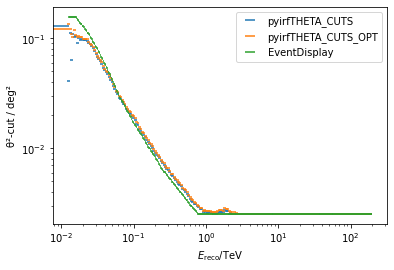

In [20]:
from astropy.table import Table

for key in ('THETA_CUTS', 'THETA_CUTS_OPT'):
    theta_cut = Table.read('../sensitivity.fits.gz', hdu=key)

    plt.errorbar(
        theta_cut['low'],
        theta_cut['cut'].quantity.to_value(u.deg)**2,
        xerr=theta_cut['high'] - theta_cut['low'],
        ls='',
        label='pyirf' + key,
    )

theta_cut_ed = irf_eventdisplay['ThetaCut;1']
plt.errorbar(
    10**theta_cut_ed.edges[:-1],
    theta_cut_ed.values**2,
    xerr=np.diff(10**theta_cut_ed.edges),
    ls='',
    label='EventDisplay',
)

plt.legend()
plt.ylabel('θ²-cut / deg²')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.yscale('log')

plt.savefig('/home/maxnoe/theta2_cut.png')

In [ ]:
from astropy.coordinates import Angle
from gammapy.maps import MapAxis
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, BgRateTable

In [ ]:
# Effective area

# Approach using gammapy

#aeff2D = EffectiveAreaTable2D.read(f'{indir_pyirf}/{infile_pyirf}', hdu=1)
#print(aeff2D)
#aeff=aeff2D.to_effective_area_table(offset=Angle('1d'), energy=energy * u.TeV)
#aeff.plot()
#plt.grid(which="both")
#plt.yscale("log")

# Manual approach
aeff_pyirf = hdul_pyirf[1]

aeff_pyirf_ENERG_LO = aeff_pyirf.data[0][0]
aeff_pyirf_EFFAREA  = aeff_pyirf.data[0][4][1]*1.e4 # there seems to be a 10**4 missing...maybe a bug in pyirf?

In [ ]:
# Angular resolution

# At the moment the format provided by pyirf is not compatible with GADF
# https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/full_enclosure/psf/index.html

psf_pyirf = hdul_pyirf[2]

In [ ]:
# Energy dispersion

# here I open manually, but I use gammapy.irf.EnergyDispersion2D to get the energy resolution

eDisp_pyirf = hdul_pyirf[3]

eDisp_pyirf_ENERG_LO = eDisp_pyirf.data[0][0]
eDisp_pyirf_ENERG_HI = eDisp_pyirf.data[0][1]

edisp2d_pyirf = EnergyDispersion2D.read(f'{indir_pyirf}/{infile_pyirf}', hdu="ENERGY DISPERSION")
edisp_pyirf = edisp2d_pyirf.to_energy_dispersion(offset=Angle('1d'), e_reco=eDisp_pyirf_ENERG_LO * u.TeV, e_true=eDisp_pyirf_ENERG_LO * u.TeV)

edisp_true_pyirf = np.asarray([(eDisp_pyirf_ENERG_HI[i]-eDisp_pyirf_ENERG_LO[i])/2. for i in range(len(eDisp_pyirf_ENERG_LO))])

resolution_pyirf = []
for e_true in edisp_true_pyirf:
    resolution_pyirf.append(edisp_pyirf.get_resolution(e_true * u.TeV))
resolution_pyirf = np.asarray(resolution_pyirf)

In [ ]:
# Background rate

background_pyirf = hdul_pyirf[4]

In [ ]:
# Differential sensitivity

sensitivity_pyirf = hdul_pyirf[8]

## Comparison

For the moment we do not require to replicate perfectly the EventDisplay output, because this depends also on:

- the configuration in config.yaml,
- the specific cuts optiization performed by EventDisplay (which has not yet been replicated in pyirf)

This comparison is here to make sure that we can produce a reliable and stable output and use it to proceed with the development.

A more detailed and complete version of this notebook will be provided with an official DL3 benchmarking.

### IRFs
[back to top](#Table-of-contents)

#### Effective area
[back to top](#Table-of-contents)

In [ ]:
zoom = 2
plt.figure(figsize=(zoom*4,zoom*3))

# Data from EventDisplay
h = input_EventDisplay["EffectiveAreaEtrue"]
x = np.asarray([(10**x_bin[1]+10**x_bin[0])/2. for x_bin in h.allbins[3:-1]])
xerr = np.asarray([(10**x_bin[1]-10**x_bin[0])/2 for x_bin in h.allbins[3:-1]])
y = h.allvalues[3:-1]
yerr = h.allvariances[3:-1]

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(1.e3, 1.e7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy [TeV]")
plt.ylabel("Effective collection area [cm^2]")
plt.grid(which="both")

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=None, fmt="o", label="EventDisplay")
plt.loglog(aeff_pyirf_ENERG_LO, aeff_pyirf_EFFAREA, drawstyle='steps-post', label="pyirf")

plt.legend(loc=4)
plt.show()

#### Angular resolution
[back to top](#Table-of-contents)

In [ ]:
zoom = 2
plt.figure(figsize=(zoom*4,zoom*3))

# Data from EventDisplay
h = input_EventDisplay["AngRes"]
x = np.asarray([(10**x_bin[1]+10**x_bin[0])/2. for x_bin in h.bins])
xerr = np.asarray([(10**x_bin[1]-10**x_bin[0])/2 for x_bin in h.bins])
y = h.values
yerr = h.variances

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(2.e-2, 1)
plt.xscale("log")
plt.xlabel("True energy [TeV]")
plt.ylabel("Angular resolution [deg]")
plt.grid(which="both")

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="o", label="EventDisplay")

plt.semilogy(psf_pyirf.columns["ENERG_LO"].array,
             psf_pyirf.columns["PSF68"].array,
             drawstyle='steps-post',
             label="pyirf")

plt.legend(loc="best")
plt.show()

#### Energy resolution
[back to top](#Table-of-contents)

In [ ]:
zoom = 2
plt.figure(figsize=(zoom*4,zoom*3))

# Data from EventDisplay
h = input_EventDisplay["ERes"]
x = np.asarray([(10**x_bin[1]+10**x_bin[0])/2. for x_bin in h.bins[1:]])
xerr = np.asarray([(10**x_bin[1]-10**x_bin[0])/2 for x_bin in h.bins[1:]])
y = h.values[1:]
yerr = h.variances[1:]

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(0., 0.3)
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Energy resolution")
plt.grid(which="both")

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="o", label="EventDisplay")
plt.semilogx(edisp_true_pyirf, resolution_pyirf, label="pyirf")

plt.legend(loc="best")
plt.show()

#### Background rate
[back to top](#Table-of-contents)

In [ ]:
zoom = 2
plt.figure(figsize=(zoom*4,zoom*3))

# Data from EventDisplay
h = input_EventDisplay["BGRate"]
x = np.asarray([(10**x_bin[1]+10**x_bin[0])/2. for x_bin in h.bins])
xerr = np.asarray([(10**x_bin[1]-10**x_bin[0])/2 for x_bin in h.bins])
y = h.values
yerr = h.variances

# Style settings
#plt.xlim(1.e-2, 2.e2)
#plt.ylim(1.e-7, 1.1)
plt.xscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Background rate [s^-1]")
plt.grid(which="both")

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="o", label="EventDisplay")
plt.loglog(background_pyirf.columns['ENERG_LO'].array,
           background_pyirf.columns['BGD'].array,
           drawstyle='steps-post',
           label="pyirf")

plt.legend(loc="best")
plt.show()